In [1]:
import sys
import argparse
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from datetime import datetime
import gym
import matplotlib
from tqdm import tqdm
from collections import deque
from random import sample
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
!nvidia-smi

Tue Nov  3 01:20:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    18W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install Box2D

     |████████████████████████████████| 1.3MB 10.3MB/s 


In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd drive/My\ Drive/CMU/rl/hw3
    %ls
except:
    print("Error loading colab folder; may not be on colab")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:



Error loading colab folder; may not be on colab


In [2]:
class Replay_Memory():
	def __init__(self, memory_size=50000, burn_in=10000):
		# The memory essentially stores transitions recorder from the agent
		# taking actions in the environment.

		# Burn in episodes define the number of episodes that are written into the memory from the
		# randomly initialized agent. Memory size is the maximum size after which old elements in the memory are replaced.
		# A simple (if not the most efficient) was to implement the memory is as a list of transitions.

		# Hint: you might find this useful:
		# 		collections.deque(maxlen=memory_size)
		self.memory_size = memory_size
		self.burn_in = burn_in
		self.transitions = deque(maxlen=memory_size)

	def sample_batch(self, batch_size=32):
		# This function returns a batch of randomly sampled transitions - i.e. state, action, reward, next state, terminal flag tuples.
		# You will feed this to your model to train.
		return sample(self.transitions, batch_size)
	
	def __len__(self):
		return len(self.transitions)

	def append(self, transition):
		# Appends transition to the memory.
		self.transitions.append(transition)

In [3]:
class DQN_Agent():
	# In this class, we will implement functions to do the following.
	# (1) Create an instance of the Q Network class.
	# (2) Create a function that constructs a policy from the Q values predicted by the Q Network.
	#		(a) Epsilon Greedy Policy.
	# 		(b) Greedy Policy.
	# (3) Create a function to train the Q Network, by interacting with the environment.
	# (4) Create a function to test the Q Network's performance on the environment.
	# (5) Create a function for Experience Replay.

	def __init__(self, env_name, render=False):
		self.eps = 0.5
		self.memory = Replay_Memory()
		self.env_name = env_name
		self.gamma = 0.99

		self.init_env() # initializes self.env; if env bugs out, just call .init_env() below

	def init_env(self):
		self.env = gym.make(self.env_name)

	def epsilon_greedy_policy(self, q_values):
		# Creating epsilon greedy probabilities to sample from.
		if (np.random.random() < self.eps): # random action with eps probability
			return np.random.randint((self.env.action_space.n))
		else: # greedy with 1-eps probability
			return np.argmax(q_values.detach().cpu().numpy())

	def greedy_policy(self, q_values):
		# Creating greedy policy for test time.
		return np.argmax(q_values.detach().cpu().numpy())

	def burn_in_memory(self, model):
		# Initialize your replay memory with a burn_in number of episodes / transitions.
		model.eval()

		# dont accumulate comp graph
		with torch.no_grad():
			# while we still need to meet memory quota
			while len(self.memory) < self.memory.burn_in:
				done = False
				state = self.env.reset()
				q_values = model(torch.Tensor(state).unsqueeze(0))
				
				# run ep
				while not done:
					action = self.epsilon_greedy_policy(q_values)

					next_state, reward, done, _ = self.env.step(action)
					self.memory.transitions.append([state, action, reward, next_state, done])

					state = next_state
					q_values = model(torch.Tensor(state).unsqueeze(0))
	
					if len(self.memory) == self.memory.burn_in:
						break

	def train(self, model, optimizer, num_episodes, batch_size):
		# In this function, we will train our network.

		# When use replay memory, you should interact with environment here, and store these
		# transitions to memory, while also updating your model.
		model.train()

		# Burn in memory if not already burned in
		if len(self.memory) < self.memory.memory_size:
			print('Burning in memory.')
			self.burn_in_memory(model)
			print('Finished burning in memory')
		else:
			print('Using existing memory')
		
		losses = []
		episodic_reward = []

		print("**BEGINNING TRAINING**")
		print(f"Will train: {num_episodes} episodes")
		print(f"Total episodes already trained: {model.num_episodes} episodes")
		print(f"Batch size: {batch_size}")
		print("-" * 20)
  
		for episode in tqdm(range(1, num_episodes + 1), position=0, leave=True):
			done = False
			state = self.env.reset()
			# test_video(self, self.env, episode)
			episode_reward = 0
			model.eval()
			with torch.no_grad():
				q_values = model(torch.Tensor(state).unsqueeze(0))
			model.train()
			td_loss = []
			# print('episode', episode)
			while not done:
				optimizer.zero_grad()
		
				action = self.epsilon_greedy_policy(q_values)

				next_state, reward, done, _ = self.env.step(action)
				episode_reward += reward

				self.memory.transitions.append((state, action, reward, next_state, done))

				# import pdb; pdb.set_trace() # TODO: remove

				# sampling batch # TODO: simplify
				batch = list(map(list, zip(*self.memory.sample_batch(batch_size))))
				states = np.array([i for i in batch[0]])
				actions = np.array([i for i in batch[1]])
				rewards = np.array([i for i in batch[2]])
				next_states = np.array([i for i in batch[3]])
				done_indicator = np.array([i for i in batch[4]])
	
				q_values = model(torch.Tensor(states))
				next_q_values = model(torch.Tensor(next_states)).detach()

				# Updating Q Values
				for idx in range(len(q_values)):
					if done_indicator[idx]:
						q_values[idx, actions[idx]] = rewards[idx]
					else:
						q_values[idx, actions[idx]] = rewards[idx] + self.gamma*torch.max(next_q_values[idx])
	  
				# Updating model
				predictions = model(torch.Tensor(states))
				loss = model.criterion(predictions, q_values)		
				loss.backward()
				optimizer.step()
	
				# Compute TD Loss
				td_loss.append(torch.sum(torch.absolute(predictions - q_values)).detach().cpu().numpy())

				state = next_state
				model.eval()
				with torch.no_grad():
					q_values = model(torch.Tensor(state).unsqueeze(0)) # ?
				model.train()

				# Store loss value for printing 
				losses.append(loss.item())

			episodic_reward.append(episode_reward)
			model.td_loss.append(np.mean(np.array(td_loss)))

			# increase total episode count
			model.num_episodes += 1
   
			if model.num_episodes % 100 == 0:
				self.eps *= 0.5 # ? why do we change eps
				mean_test_reward, stdev_test_reward, test_avg_trj_len, test_std_trj_len = self.test(model)

				# store performance stats
				model.mean_rewards.append(mean_test_reward)
				model.stdev_rewards.append(stdev_test_reward)
				model.mean_trj_lens.append(test_avg_trj_len)
				model.stdev_trj_lens.append(test_std_trj_len)

				# print training stats
				print(f"\nCurrent Episode: {episode}, Total # Episodes: {model.num_episodes}")
				# print(f"(train) current_loss: {loss.item()}, (train) mean_loss: {np.mean(losses)}")
				# print(f"(train) mean_reward: {mean_test_reward}, (train) stdev_reward: {stdev_test_reward}")
				print(f"(test) mean_reward: {mean_test_reward}, TD Loss: {np.mean(model.td_loss)}")
				# print(f"(test) avg_trj_len: {test_avg_trj_len}")
				print("--------------------------")

				# reset loss tracking to get running average every 100 eps
				rewards = []
				losses = []

				# reset to train mode
				model.train()
			
			# save model every 500 eps
			# if model.num_episodes % 500 == 0:
			# 	model.save_model_weights()
   
		return episodic_reward, test_reward

	def test(self, model):
	# 	# Evaluate the performance of your agent over 100 episodes, by calculating average cummulative rewards (returns) for the 100 episodes.
	# 	# Here you need to interact with the environment, irrespective of whether you are using a memory.
		test_eps_rewards = []
		trj_lens = []
		
		# while not accumulating comp graph,
		model.eval()
		with torch.no_grad():
			# for 20 episodes,
			for i in range(20):
				episode_reward = 0
				trj_len = 0
				done = False
				state = self.env.reset()
				q_values = model(torch.Tensor(state).unsqueeze(0))
				
				# create a trajectory and store its total reward and length
				while not done:
					action = self.greedy_policy(q_values)
		
					next_state, reward, done, _ = self.env.step(action)
					episode_reward += reward

					trj_len += 1

					state = next_state
					q_values = model(torch.Tensor(state).unsqueeze(0))
				test_eps_rewards.append(episode_reward)
				trj_lens.append(trj_len)
		
		# return avg and stdev reward, as well as the avg length of the trajectories
		return np.mean(test_eps_rewards), np.std(test_eps_rewards), np.mean(trj_lens), np.std(trj_lens)

In [4]:
def plot_training(model, k=100):
    mean_rewards, stdev_rewards = model.mean_rewards, model.stdev_rewards

    above = []
    below = []

    # add and subtract the stdev to current mean
    for mu, sigma in zip(mean_rewards, stdev_rewards):
         above.append(mu + sigma)
         below.append(mu - sigma)

    # breakpoint()
    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(len(mean_rewards)) * k, mean_rewards, label="mean_rewards")
    plt.fill_between(np.arange(len(mean_rewards)) * k, above, below, alpha=0.5, color='y', label="stdev_reward")
    plt.title(f"Mean/Stdev Eval Reward for {model.env_name}, REINFORCE, k={k}, trained: {model.num_episodes} episodes")
    plt.ylabel(f"Reward")
    plt.xlabel(f"# Episodes of training (eval every {k})")
    plt.legend()
    plt.savefig(f"p3_{model.env_name}_{datetime.now().isoformat('_').replace(':', '_')}.png", dpi=300)
    plt.show()

In [5]:
def plot_trj_lens(model, k=100):
    mean_trj_lens, stdev_trj_lens = model.mean_trj_lens, model.stdev_trj_lens

    above = []
    below = []

    # add and subtract the stdev to current mean
    for mu, sigma in zip(mean_trj_lens, stdev_trj_lens):
         above.append(mu + sigma)
         below.append(mu - sigma)
    # breakpoint()
    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(len(mean_trj_lens)) * k, mean_trj_lens, label="mean_trj_lens")
    plt.fill_between(np.arange(len(mean_trj_lens)) * k, above, below, alpha=0.5, color='y', label="stdev_trj_lens")
    plt.title(f"Mean/Stdev Trajectory Lengths for {model.env_name}, DQN, k={k}, trained: {model.num_episodes} episodes")
    plt.ylabel(f"Trajectory Length")
    plt.xlabel(f"# Episodes of training (eval 20 eps every {k})")
    plt.legend()
    plt.savefig(f"q3_trj_lens_{model.env_name}_{datetime.now().isoformat('_').replace(':', '_')}.png", dpi=300)
    plt.show()

In [18]:
class QNetwork(nn.Module):
	# This class essentially defines the network architecture.
	# The network should take in state of the world as an input,
	# and output Q values of the actions available to the agent as the output.

	def __init__(self, env_name, input_size, output_size):
		# Define your network architecture here. It is also a good idea to define any training operations
		# and optimizers here, initialize your variables, or alternately compile your model here.
		super(QNetwork, self).__init__()
		self.env_name = env_name
		self.input_size = input_size
		self.output_size = output_size

        # init layers
		self.net = nn.Sequential(
				nn.Linear(self.input_size, 32),
				nn.ReLU(),
				nn.Linear(32, 64),
				nn.ReLU(),
				nn.Linear(64, 128),
				nn.ReLU(),
				nn.Linear(128, 64),
				nn.ReLU(),
				nn.Linear(64, 32),
				nn.ReLU(),
				nn.Linear(32, self.output_size),
		)

		self.init_weights()

        # always same criterion so might as well put it here
		self.criterion = nn.MSELoss()

        # tracking stats
		self.mean_rewards = []
		self.stdev_rewards = []
		self.mean_trj_lens = []
		self.stdev_trj_lens = []
		self.td_loss = []
		self.num_episodes = 0

	def save_model_weights(self):
		# Helper function to save your model / weights.
		torch.save(self.net.state_dict(), f"q3_models/{self.env_name}_{self.num_episodes}_{datetime.now().isoformat('_').replace(':', '_')}.model")
	
	def forward(self, x):
		return self.net(x)

	def load_model(self, model_file):
		# Helper function to load an existing model.
		self.net.load_state_dict(torch.load("q3_models/"+model_file))
# nn.init.xavier_uniform_(m.weight, gain=0.3)
                # scale = 1.0
                # n = np.mean(m.weight.shape)
                # alpha = np.sqrt(3 * scale / n)
                # nn.init.uniform_(m.weight, a=-alpha, b=alpha)
                # nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
	def init_weights(self):
		for m in self.net:
			if isinstance(m, nn.Linear):
				nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') # torch 1.7.0 new default, better init strategy generally
				nn.init.zeros_(m.bias)

#Mountain Car Env

In [19]:
# init dqn agent (WARNING: rerunning this will wipe memory)
env_name = 'MountainCar-v0'
dqn_agent = DQN_Agent(env_name)

In [20]:
dqn_agent.init_env()

In [21]:
# init model
input_size = dqn_agent.env.observation_space.shape[0]
output_size = dqn_agent.env.action_space.n

model = QNetwork(env_name, input_size, output_size)
# print(device)
# model = model.to(device)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [23]:
# run training
batch_size = 32
num_episodes = 10000
train_rewards, test_reward = dqn_agent.train(model, optimizer, num_episodes, batch_size)

Burning in memory.


  0%|          | 0/10000 [00:00<?, ?it/s]

Finished burning in memory
**BEGINNING TRAINING**
Will train: 10000 episodes
Total episodes already trained: 0 episodes
Batch size: 32
--------------------


  1%|          | 100/10000 [01:40<3:42:40,  1.35s/it]


Current Episode: 100, Total # Episodes: 100
(test) mean_reward: -200.0, TD Loss: 20.781543731689453
--------------------------


  2%|▏         | 200/10000 [03:21<3:41:00,  1.35s/it]


Current Episode: 200, Total # Episodes: 200
(test) mean_reward: -200.0, TD Loss: 20.187965393066406
--------------------------


  3%|▎         | 300/10000 [05:03<3:42:20,  1.38s/it]


Current Episode: 300, Total # Episodes: 300
(test) mean_reward: -200.0, TD Loss: 19.7679443359375
--------------------------


  4%|▍         | 400/10000 [06:46<3:35:09,  1.34s/it]


Current Episode: 400, Total # Episodes: 400
(test) mean_reward: -200.0, TD Loss: 19.746238708496094
--------------------------


  5%|▌         | 500/10000 [08:20<2:56:23,  1.11s/it]


Current Episode: 500, Total # Episodes: 500
(test) mean_reward: -200.0, TD Loss: 19.65021324157715
--------------------------


  6%|▌         | 600/10000 [09:36<2:29:04,  1.05it/s]


Current Episode: 600, Total # Episodes: 600
(test) mean_reward: -150.6, TD Loss: 19.033700942993164
--------------------------


  7%|▋         | 700/10000 [10:50<2:37:33,  1.02s/it]


Current Episode: 700, Total # Episodes: 700
(test) mean_reward: -163.4, TD Loss: 18.263212203979492
--------------------------


  8%|▊         | 800/10000 [11:59<2:19:17,  1.10it/s]


Current Episode: 800, Total # Episodes: 800
(test) mean_reward: -132.0, TD Loss: 17.324188232421875
--------------------------


  9%|▉         | 900/10000 [13:05<2:20:55,  1.08it/s]


Current Episode: 900, Total # Episodes: 900
(test) mean_reward: -181.3, TD Loss: 16.41981315612793
--------------------------


 10%|█         | 1000/10000 [14:07<1:53:15,  1.32it/s]


Current Episode: 1000, Total # Episodes: 1000
(test) mean_reward: -105.9, TD Loss: 15.687403678894043
--------------------------


 11%|█         | 1100/10000 [15:04<2:03:54,  1.20it/s]


Current Episode: 1100, Total # Episodes: 1100
(test) mean_reward: -124.05, TD Loss: 14.966854095458984
--------------------------


 12%|█▏        | 1200/10000 [16:03<2:00:54,  1.21it/s]


Current Episode: 1200, Total # Episodes: 1200
(test) mean_reward: -105.25, TD Loss: 14.331881523132324
--------------------------


 13%|█▎        | 1300/10000 [16:59<1:51:29,  1.30it/s]


Current Episode: 1300, Total # Episodes: 1300
(test) mean_reward: -128.3, TD Loss: 13.747247695922852
--------------------------


 14%|█▍        | 1400/10000 [17:54<1:41:00,  1.42it/s]


Current Episode: 1400, Total # Episodes: 1400
(test) mean_reward: -103.0, TD Loss: 13.165708541870117
--------------------------


 15%|█▌        | 1500/10000 [18:48<1:52:02,  1.26it/s]


Current Episode: 1500, Total # Episodes: 1500
(test) mean_reward: -101.95, TD Loss: 12.64697265625
--------------------------


 16%|█▌        | 1600/10000 [19:46<1:48:03,  1.30it/s]


Current Episode: 1600, Total # Episodes: 1600
(test) mean_reward: -107.55, TD Loss: 12.214268684387207
--------------------------


 17%|█▋        | 1700/10000 [20:47<1:50:38,  1.25it/s]


Current Episode: 1700, Total # Episodes: 1700
(test) mean_reward: -105.5, TD Loss: 11.870615005493164
--------------------------


 18%|█▊        | 1800/10000 [21:46<1:41:03,  1.35it/s]


Current Episode: 1800, Total # Episodes: 1800
(test) mean_reward: -101.0, TD Loss: 11.567191123962402
--------------------------


 19%|█▉        | 1900/10000 [22:44<1:40:22,  1.35it/s]


Current Episode: 1900, Total # Episodes: 1900
(test) mean_reward: -100.6, TD Loss: 11.301122665405273
--------------------------


 20%|██        | 2000/10000 [23:41<1:41:37,  1.31it/s]


Current Episode: 2000, Total # Episodes: 2000
(test) mean_reward: -97.55, TD Loss: 11.072509765625
--------------------------


 21%|██        | 2100/10000 [24:39<1:29:30,  1.47it/s]


Current Episode: 2100, Total # Episodes: 2100
(test) mean_reward: -102.05, TD Loss: 10.84713363647461
--------------------------


 22%|██▏       | 2200/10000 [25:37<1:38:15,  1.32it/s]


Current Episode: 2200, Total # Episodes: 2200
(test) mean_reward: -109.35, TD Loss: 10.641135215759277
--------------------------


 23%|██▎       | 2300/10000 [26:34<1:41:01,  1.27it/s]


Current Episode: 2300, Total # Episodes: 2300
(test) mean_reward: -157.5, TD Loss: 10.44742488861084
--------------------------


 24%|██▍       | 2400/10000 [27:30<1:34:04,  1.35it/s]


Current Episode: 2400, Total # Episodes: 2400
(test) mean_reward: -103.1, TD Loss: 10.259011268615723
--------------------------


 25%|██▌       | 2500/10000 [28:27<1:28:51,  1.41it/s]


Current Episode: 2500, Total # Episodes: 2500
(test) mean_reward: -100.95, TD Loss: 10.08416748046875
--------------------------


 26%|██▌       | 2600/10000 [29:25<1:34:57,  1.30it/s]


Current Episode: 2600, Total # Episodes: 2600
(test) mean_reward: -100.65, TD Loss: 9.918746948242188
--------------------------


 27%|██▋       | 2700/10000 [30:19<1:30:33,  1.34it/s]


Current Episode: 2700, Total # Episodes: 2700
(test) mean_reward: -131.85, TD Loss: 9.741806030273438
--------------------------


 28%|██▊       | 2800/10000 [31:15<1:25:29,  1.40it/s]


Current Episode: 2800, Total # Episodes: 2800
(test) mean_reward: -103.35, TD Loss: 9.594070434570312
--------------------------


 29%|██▉       | 2900/10000 [32:13<1:35:31,  1.24it/s]


Current Episode: 2900, Total # Episodes: 2900
(test) mean_reward: -119.0, TD Loss: 9.4702787399292
--------------------------


 30%|███       | 3000/10000 [33:11<1:46:18,  1.10it/s]


Current Episode: 3000, Total # Episodes: 3000
(test) mean_reward: -175.35, TD Loss: 9.362506866455078
--------------------------


 31%|███       | 3100/10000 [34:10<1:41:14,  1.14it/s]


Current Episode: 3100, Total # Episodes: 3100
(test) mean_reward: -165.7, TD Loss: 9.254066467285156
--------------------------


 32%|███▏      | 3200/10000 [35:05<1:23:02,  1.36it/s]


Current Episode: 3200, Total # Episodes: 3200
(test) mean_reward: -99.95, TD Loss: 9.156900405883789
--------------------------


 33%|███▎      | 3300/10000 [36:02<1:23:27,  1.34it/s]


Current Episode: 3300, Total # Episodes: 3300
(test) mean_reward: -128.25, TD Loss: 9.06086254119873
--------------------------


 34%|███▍      | 3400/10000 [36:57<1:37:00,  1.13it/s]


Current Episode: 3400, Total # Episodes: 3400
(test) mean_reward: -106.15, TD Loss: 8.958991050720215
--------------------------


 35%|███▌      | 3500/10000 [37:52<1:20:29,  1.35it/s]


Current Episode: 3500, Total # Episodes: 3500
(test) mean_reward: -111.45, TD Loss: 8.849714279174805
--------------------------


 36%|███▌      | 3600/10000 [38:51<1:19:02,  1.35it/s]


Current Episode: 3600, Total # Episodes: 3600
(test) mean_reward: -99.35, TD Loss: 8.756729125976562
--------------------------


 37%|███▋      | 3700/10000 [39:48<1:22:55,  1.27it/s]


Current Episode: 3700, Total # Episodes: 3700
(test) mean_reward: -142.7, TD Loss: 8.682263374328613
--------------------------


 38%|███▊      | 3800/10000 [40:46<1:16:24,  1.35it/s]


Current Episode: 3800, Total # Episodes: 3800
(test) mean_reward: -105.05, TD Loss: 8.61383056640625
--------------------------


 39%|███▉      | 3900/10000 [41:41<1:09:22,  1.47it/s]


Current Episode: 3900, Total # Episodes: 3900
(test) mean_reward: -97.4, TD Loss: 8.547744750976562
--------------------------


 40%|████      | 4000/10000 [42:37<1:11:10,  1.40it/s]


Current Episode: 4000, Total # Episodes: 4000
(test) mean_reward: -132.05, TD Loss: 8.48371696472168
--------------------------


 41%|████      | 4100/10000 [43:33<1:12:20,  1.36it/s]


Current Episode: 4100, Total # Episodes: 4100
(test) mean_reward: -114.8, TD Loss: 8.415234565734863
--------------------------


 42%|████▏     | 4200/10000 [44:34<1:19:54,  1.21it/s]


Current Episode: 4200, Total # Episodes: 4200
(test) mean_reward: -120.8, TD Loss: 8.356746673583984
--------------------------


 43%|████▎     | 4300/10000 [45:34<1:33:44,  1.01it/s]


Current Episode: 4300, Total # Episodes: 4300
(test) mean_reward: -155.5, TD Loss: 8.303529739379883
--------------------------


 44%|████▍     | 4400/10000 [46:33<1:04:13,  1.45it/s]


Current Episode: 4400, Total # Episodes: 4400
(test) mean_reward: -98.25, TD Loss: 8.252138137817383
--------------------------


 45%|████▌     | 4500/10000 [47:33<1:11:03,  1.29it/s]


Current Episode: 4500, Total # Episodes: 4500
(test) mean_reward: -101.1, TD Loss: 8.213935852050781
--------------------------


 46%|████▌     | 4600/10000 [48:34<1:21:03,  1.11it/s]


Current Episode: 4600, Total # Episodes: 4600
(test) mean_reward: -126.05, TD Loss: 8.1729736328125
--------------------------


 47%|████▋     | 4700/10000 [49:33<1:20:24,  1.10it/s]


Current Episode: 4700, Total # Episodes: 4700
(test) mean_reward: -160.45, TD Loss: 8.124072074890137
--------------------------


 48%|████▊     | 4800/10000 [50:32<1:03:32,  1.36it/s]


Current Episode: 4800, Total # Episodes: 4800
(test) mean_reward: -98.35, TD Loss: 8.07571792602539
--------------------------


 49%|████▉     | 4900/10000 [51:30<1:03:20,  1.34it/s]


Current Episode: 4900, Total # Episodes: 4900
(test) mean_reward: -103.65, TD Loss: 8.02558708190918
--------------------------


 50%|█████     | 5000/10000 [52:31<1:07:34,  1.23it/s]


Current Episode: 5000, Total # Episodes: 5000
(test) mean_reward: -107.95, TD Loss: 7.983797073364258
--------------------------


 51%|█████     | 5100/10000 [53:32<1:07:17,  1.21it/s]


Current Episode: 5100, Total # Episodes: 5100
(test) mean_reward: -100.4, TD Loss: 7.949290752410889
--------------------------


 52%|█████▏    | 5200/10000 [54:33<58:01,  1.38it/s]


Current Episode: 5200, Total # Episodes: 5200
(test) mean_reward: -100.1, TD Loss: 7.911772727966309
--------------------------


 53%|█████▎    | 5300/10000 [55:35<1:14:40,  1.05it/s]


Current Episode: 5300, Total # Episodes: 5300
(test) mean_reward: -156.7, TD Loss: 7.876266002655029
--------------------------


 54%|█████▍    | 5400/10000 [56:36<58:36,  1.31it/s]


Current Episode: 5400, Total # Episodes: 5400
(test) mean_reward: -104.4, TD Loss: 7.849024295806885
--------------------------


 55%|█████▌    | 5500/10000 [57:36<58:00,  1.29it/s]


Current Episode: 5500, Total # Episodes: 5500
(test) mean_reward: -100.6, TD Loss: 7.817800998687744
--------------------------


 56%|█████▌    | 5600/10000 [58:39<53:34,  1.37it/s]


Current Episode: 5600, Total # Episodes: 5600
(test) mean_reward: -102.2, TD Loss: 7.789341449737549
--------------------------


 57%|█████▋    | 5700/10000 [59:45<54:26,  1.32it/s]


Current Episode: 5700, Total # Episodes: 5700
(test) mean_reward: -107.75, TD Loss: 7.75991153717041
--------------------------


 58%|█████▊    | 5800/10000 [1:00:48<59:22,  1.18it/s]


Current Episode: 5800, Total # Episodes: 5800
(test) mean_reward: -106.25, TD Loss: 7.743611812591553
--------------------------


 59%|█████▉    | 5900/10000 [1:01:52<55:18,  1.24it/s]


Current Episode: 5900, Total # Episodes: 5900
(test) mean_reward: -115.85, TD Loss: 7.738896369934082
--------------------------


 60%|██████    | 6000/10000 [1:02:55<50:25,  1.32it/s]


Current Episode: 6000, Total # Episodes: 6000
(test) mean_reward: -100.65, TD Loss: 7.735610485076904
--------------------------


 61%|██████    | 6100/10000 [1:03:57<50:09,  1.30it/s]


Current Episode: 6100, Total # Episodes: 6100
(test) mean_reward: -101.5, TD Loss: 7.730395793914795
--------------------------


 62%|██████▏   | 6200/10000 [1:04:59<1:01:29,  1.03it/s]


Current Episode: 6200, Total # Episodes: 6200
(test) mean_reward: -187.25, TD Loss: 7.716755390167236
--------------------------


 63%|██████▎   | 6300/10000 [1:06:02<48:24,  1.27it/s]


Current Episode: 6300, Total # Episodes: 6300
(test) mean_reward: -104.6, TD Loss: 7.702671527862549
--------------------------


 64%|██████▍   | 6400/10000 [1:07:07<46:14,  1.30it/s]


Current Episode: 6400, Total # Episodes: 6400
(test) mean_reward: -103.2, TD Loss: 7.695835113525391
--------------------------


 65%|██████▌   | 6500/10000 [1:08:08<46:32,  1.25it/s]


Current Episode: 6500, Total # Episodes: 6500
(test) mean_reward: -104.5, TD Loss: 7.679422855377197
--------------------------


 66%|██████▌   | 6600/10000 [1:09:10<46:06,  1.23it/s]


Current Episode: 6600, Total # Episodes: 6600
(test) mean_reward: -101.75, TD Loss: 7.665575981140137
--------------------------


 67%|██████▋   | 6700/10000 [1:10:12<42:18,  1.30it/s]


Current Episode: 6700, Total # Episodes: 6700
(test) mean_reward: -102.35, TD Loss: 7.652542591094971
--------------------------


 68%|██████▊   | 6800/10000 [1:11:14<42:15,  1.26it/s]


Current Episode: 6800, Total # Episodes: 6800
(test) mean_reward: -105.85, TD Loss: 7.635776519775391
--------------------------


 69%|██████▉   | 6900/10000 [1:12:16<39:01,  1.32it/s]


Current Episode: 6900, Total # Episodes: 6900
(test) mean_reward: -99.9, TD Loss: 7.616232872009277
--------------------------


 70%|███████   | 7000/10000 [1:13:19<38:32,  1.30it/s]


Current Episode: 7000, Total # Episodes: 7000
(test) mean_reward: -109.1, TD Loss: 7.594411849975586
--------------------------


 71%|███████   | 7100/10000 [1:14:23<41:01,  1.18it/s]


Current Episode: 7100, Total # Episodes: 7100
(test) mean_reward: -121.8, TD Loss: 7.585550785064697
--------------------------


 72%|███████▏  | 7200/10000 [1:15:30<38:15,  1.22it/s]


Current Episode: 7200, Total # Episodes: 7200
(test) mean_reward: -100.85, TD Loss: 7.580945014953613
--------------------------


 73%|███████▎  | 7300/10000 [1:16:34<36:37,  1.23it/s]


Current Episode: 7300, Total # Episodes: 7300
(test) mean_reward: -99.8, TD Loss: 7.57492733001709
--------------------------


 74%|███████▍  | 7400/10000 [1:17:35<34:17,  1.26it/s]


Current Episode: 7400, Total # Episodes: 7400
(test) mean_reward: -103.25, TD Loss: 7.556655406951904
--------------------------


 75%|███████▌  | 7500/10000 [1:18:37<32:14,  1.29it/s]


Current Episode: 7500, Total # Episodes: 7500
(test) mean_reward: -101.65, TD Loss: 7.532825946807861
--------------------------


 76%|███████▌  | 7600/10000 [1:19:38<30:40,  1.30it/s]


Current Episode: 7600, Total # Episodes: 7600
(test) mean_reward: -98.1, TD Loss: 7.505260944366455
--------------------------


 77%|███████▋  | 7700/10000 [1:20:41<31:00,  1.24it/s]


Current Episode: 7700, Total # Episodes: 7700
(test) mean_reward: -99.95, TD Loss: 7.477555751800537
--------------------------


 78%|███████▊  | 7800/10000 [1:21:48<32:31,  1.13it/s]


Current Episode: 7800, Total # Episodes: 7800
(test) mean_reward: -123.0, TD Loss: 7.461531639099121
--------------------------


 79%|███████▉  | 7900/10000 [1:22:51<30:47,  1.14it/s]


Current Episode: 7900, Total # Episodes: 7900
(test) mean_reward: -99.25, TD Loss: 7.452201843261719
--------------------------


 80%|████████  | 8000/10000 [1:23:56<28:04,  1.19it/s]


Current Episode: 8000, Total # Episodes: 8000
(test) mean_reward: -99.1, TD Loss: 7.4482245445251465
--------------------------


 81%|████████  | 8100/10000 [1:25:03<25:57,  1.22it/s]


Current Episode: 8100, Total # Episodes: 8100
(test) mean_reward: -105.6, TD Loss: 7.454124450683594
--------------------------


 82%|████████▏ | 8200/10000 [1:26:05<22:53,  1.31it/s]


Current Episode: 8200, Total # Episodes: 8200
(test) mean_reward: -101.0, TD Loss: 7.4597249031066895
--------------------------


 83%|████████▎ | 8300/10000 [1:27:09<23:24,  1.21it/s]


Current Episode: 8300, Total # Episodes: 8300
(test) mean_reward: -104.25, TD Loss: 7.457837104797363
--------------------------


 84%|████████▍ | 8400/10000 [1:28:12<21:18,  1.25it/s]


Current Episode: 8400, Total # Episodes: 8400
(test) mean_reward: -99.95, TD Loss: 7.453219890594482
--------------------------


 85%|████████▌ | 8500/10000 [1:29:14<19:25,  1.29it/s]


Current Episode: 8500, Total # Episodes: 8500
(test) mean_reward: -99.2, TD Loss: 7.450803279876709
--------------------------


 86%|████████▌ | 8600/10000 [1:30:13<17:40,  1.32it/s]


Current Episode: 8600, Total # Episodes: 8600
(test) mean_reward: -99.5, TD Loss: 7.440175533294678
--------------------------


KeyboardInterrupt: ignored

In [ ]:
  for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-3

#Cartpole Result

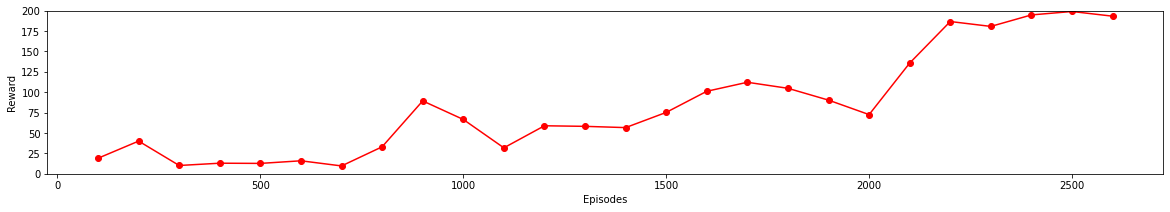

#Mountain Car Env

In [ ]:
environments = ['CartPole-v0', 'MountainCar-v0']
env = gym.make(environments[1])
print(env.observation_space)
print(env.observation_space.sample().size)
dqn_agent = DQN_Agent(env)
train_reward, test_reward = dqn_agent.train()
x = np.array(list(range(1, len(test_reward) + 1)))
x = x*100
axes = plt.gca()
axes.set_ylim([0,200])
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.plot(x, test_reward,  marker='o', color='r', 
label='Square')
plt.savefig('Avg R MountainCar')

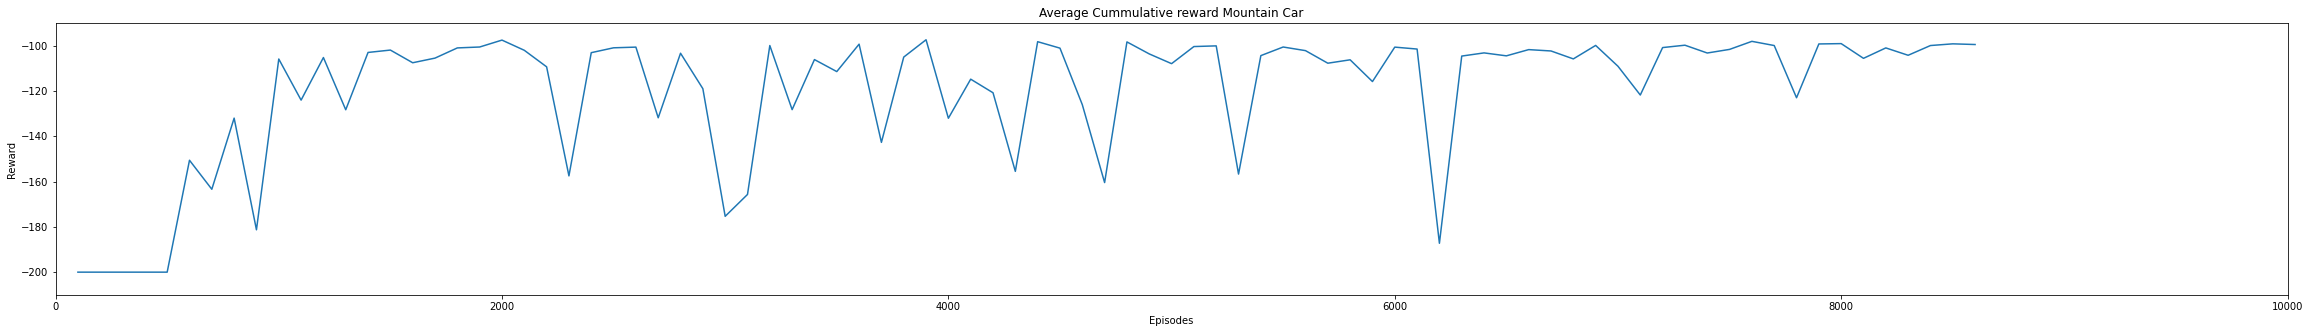

In [33]:
x = np.array(list(range(1, len(model.mean_rewards) + 1)))
x = x*100
axes = plt.gca()
axes.set_ylim([-210, -90])
axes.set_xlim([0, 10000])
plt.rcParams["figure.figsize"] = (40,5)
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.title('Average Cummulative reward Mountain Car')
plt.plot(x, model.mean_rewards)
# plt.plot(model.td_loss)
plt.savefig('Avg R Cartpole')

In [ ]:
print(model.mean_rewards)

[-200.0, -200.0, -148.0, -200.0, -186.35, -103.95, -119.1, -139.95, -100.5, -133.05, -132.7, -187.75, -142.05, -200.0, -139.3, -179.65, -136.15, -154.8, -200.0, -172.75, -161.7, -175.7, -101.45, -121.6, -135.9, -111.3, -111.75, -179.15, -133.05, -132.9, -158.75, -197.2, -200.0, -152.6, -113.15, -178.35, -137.2, -168.5, -142.15, -182.05, -137.3, -200.0, -114.55, -200.0, -157.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -142.95, -145.95, -130.15, -120.9, -124.0, -141.9, -126.9, -200.0, -135.95, -151.15, -135.05, -161.95, -183.1, -192.75, -152.45, -153.05, -165.85, -146.8, -114.35, -126.65, -148.8, -183.3, -168.85, -162.55, -134.15, -149.85, -113.0, -153.95, -136.2, -200.0, -131.2, -143.55, -200.0, -180.0, -200.0, -200.0, -137.35, -141.9, -159.65, -200.0, -194.8, -200.0, -153.25, -200.0, -137.75, -180.95, -183.0, -154.75, -154.95]


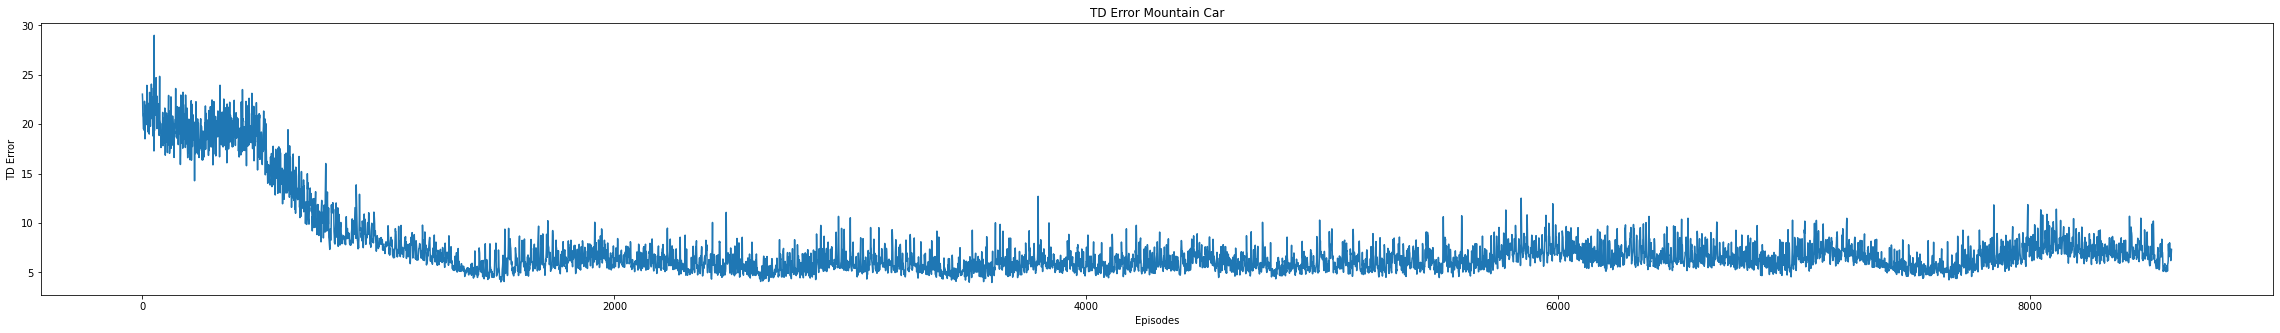

In [32]:
plt.ylabel('TD Error')
plt.xlabel('Episodes')
plt.title('TD Error Mountain Car')
plt.plot(model.td_loss)